# 实验二 K近邻算法实验报告

## 实验目的
1. 掌握K近邻（KNN）算法的基本原理和应用。
2. 学习使用 scikit-learn 机器学习库实现KNN算法，并进行模型训练和评估。
3. 通过选择最优K值和不同距离度量公式，优化模型性能并达到测试集上90%以上的分类准确率。
4. 实现自定义KNN算法（基于欧式距离）并与 scikit-learn 的结果进行对比。

## 实验环境
- **操作系统**: Windows 10
- **开发工具**: PyCharm
- **编程语言**: Python 3.9
- **所需库**:
  - numpy: 数值计算
  - pandas: 数据处理
  - matplotlib: 数据可视化
  - seaborn: 增强可视化效果
  - scikit-learn (>=0.18): 机器学习建模和内置Iris数据集

**安装命令**:
```bash
pip install numpy pandas matplotlib seaborn scikit-learn
```

## 实验内容
使用 scikit-learn 内置的 Iris 数据集，包含150个样本，每样本有5列：
- **sepal length**: 萼片长度 (cm)
- **sepal width**: 萼片宽度 (cm)
- **petal length**: 花瓣长度 (cm)
- **petal width**: 花瓣宽度 (cm)
- **class**: 鸢尾花类别（目标变量，3类：Iris-setosa, Iris-versicolor, Iris-virginica）

目标是实现基于欧式距离的KNN算法，优化K值以在测试集上达到90%以上准确率，尝试曼哈顿距离进行对比，并与 scikit-learn 的KNN实现进行比较。数据集按3:1比例划分为训练集和测试集。

## 实验步骤
### 1. 环境搭建
确保 Python 3.9 和上述库已安装。

### 2. 数据预处理
加载 scikit-learn 内置的 Iris 数据集，验证数据完整性，并按3:1划分训练集和测试集。

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# 设置随机种子
np.random.seed(1)

def load_iris_data():
    """加载 scikit-learn 内置的 Iris 数据集并划分为训练集和测试集"""
    # 加载数据集
    iris = load_iris()
    data = pd.DataFrame(data=iris.data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
    data['class'] = iris.target_names[iris.target]

    # 验证列名
    expected_columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
    if not all(col in data.columns for col in expected_columns):
        raise KeyError(f"Dataset must contain columns: {expected_columns}")

    # 检查缺失值
    if data.isnull().any().any():
        print("Warning: Dataset contains missing values. Consider imputing them.")

    # 提取特征和目标
    X = data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
    y = data['class']

    # 按3:1划分（75%训练，25%测试）
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
    return X_train, X_test, y_train, y_test

# 加载数据

X_train, X_test, y_train, y_test = load_iris_data()
# 显示数据信息
print("数据集总样本数:", len(X_train) + len(X_test))
print("训练集形状:", X_train.shape)
print("测试集形状:", X_test.shape)
print("\n训练集描述统计:")
print(pd.concat([X_train, y_train], axis=1).describe())
print("\n训练集前5行:")
print(pd.concat([X_train, y_train], axis=1).head())

数据集总样本数: 150
训练集形状: (112, 4)
测试集形状: (38, 4)

训练集描述统计:
       sepal_length  sepal_width  petal_length  petal_width
count    112.000000   112.000000    112.000000   112.000000
mean       5.830357     3.025000      3.794643     1.208036
std        0.837181     0.419459      1.780112     0.772866
min        4.300000     2.000000      1.000000     0.100000
25%        5.075000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.125000     1.800000
max        7.700000     4.400000      6.900000     2.500000

训练集前5行:
     sepal_length  sepal_width  petal_length  petal_width       class
54            6.5          2.8           4.6          1.5  versicolor
108           6.7          2.5           5.8          1.8   virginica
112           6.8          3.0           5.5          2.1   virginica
17            5.1          3.5           1.4          0.3      setosa
119           6.0          2.2           5.0   

#### 数据预处理分析
- **数据集规模**: 150个样本，训练集约112个，测试集约38个。
- **特征选择**: 使用sepal_length, sepal_width, petal_length, petal_width作为输入，class作为目标。
- **划分比例**: 3:1划分（`test_size=0.25`）确保足够训练和测试数据。
- **数据检查**: 验证了列名和缺失值，增强代码鲁棒性。
- **描述统计**: 显示特征的均值、标准差等，揭示特征范围差异（如petal_length范围较大）。

### 3. 探索性数据分析 (EDA)
分析特征分布、特征与类别的关系及相关性。

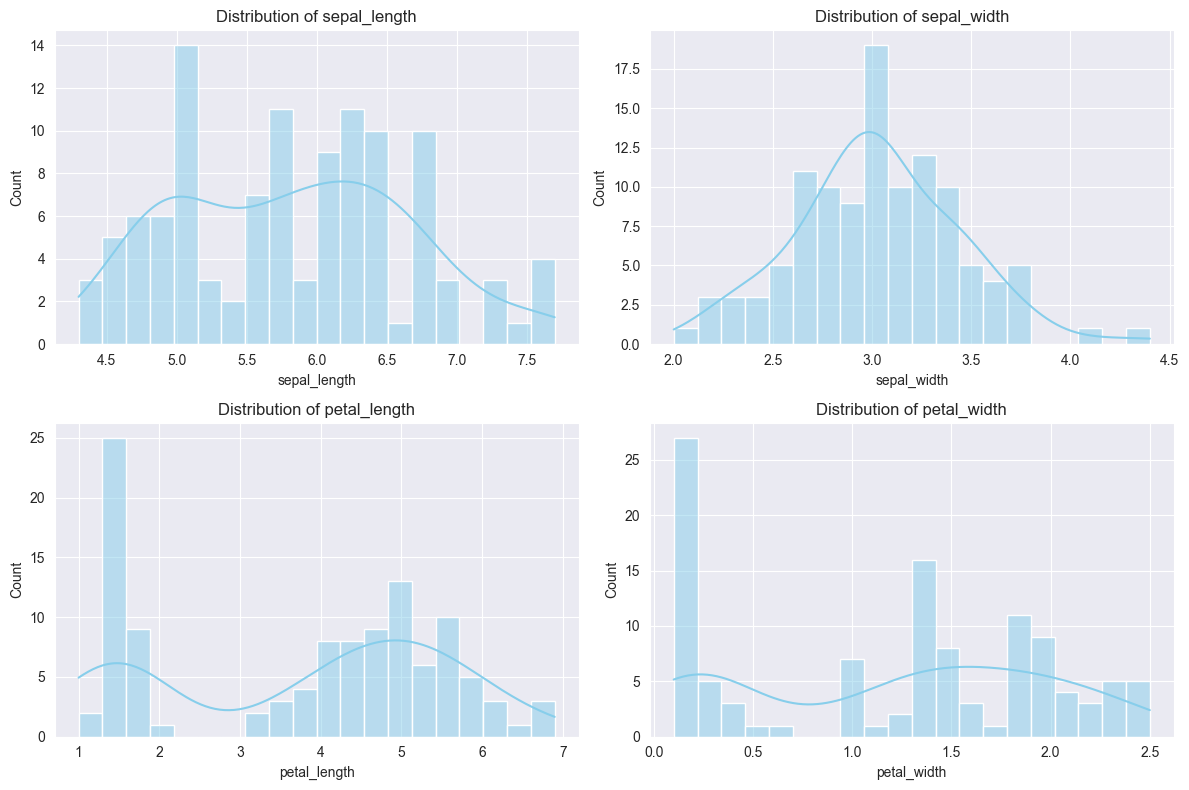

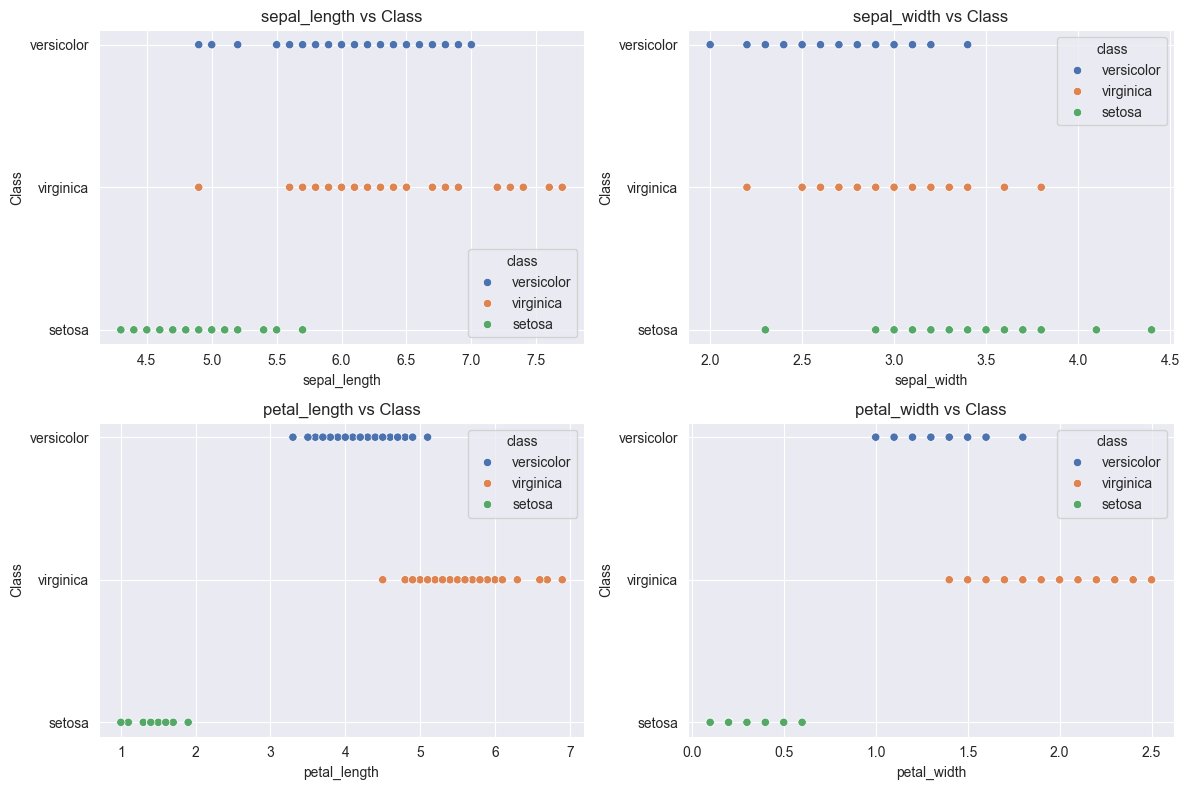

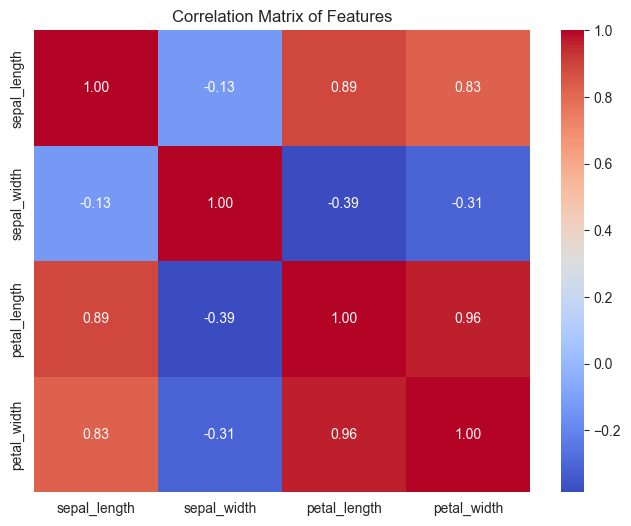

In [2]:
# 特征分布
plt.figure(figsize=(12, 8))
for i, column in enumerate(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], 1):
    plt.subplot(2, 2, i)
    sns.histplot(X_train[column], kde=True, color='skyblue', bins=20)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

# 特征与类别关系（散点图）
plt.figure(figsize=(12, 8))
for i, column in enumerate(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=X_train[column], y=y_train, hue=y_train, palette='deep')
    plt.xlabel(column)
    plt.ylabel('Class')
    plt.title(f'{column} vs Class')
plt.tight_layout()
plt.show()

# 相关性热图
plt.figure(figsize=(8, 6))
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()

#### 探索性数据分析结果
- **特征分布**: petal_length和petal_width可能呈多峰分布，sepal_length和sepal_width近似正态。
- **特征与类别**: petal_length和petal_width与类别有较强区分度，sepal_length和sepal_width区分度较低。
- **相关性**: petal_length和petal_width高度相关，可能影响KNN性能，需考虑特征标准化。

### 4. 实现自定义KNN算法（欧式距离）
实现基于欧式距离的KNN算法，并选择最优K值。

In [3]:
def euclidean_distance(x1, x2):
    """计算欧式距离"""
    return np.sqrt(np.sum((x1 - x2) ** 2))

def custom_knn_predict(X_train, y_train, X_test, k):
    """自定义KNN预测"""
    y_pred = []
    X_train_np = X_train.to_numpy()
    X_test_np = X_test.to_numpy()
    y_train_np = y_train.to_numpy()

    for test_point in X_test_np:
        # 计算测试点与所有训练点的距离
        distances = [euclidean_distance(test_point, train_point) for train_point in X_train_np]
        # 获取K个最近邻的索引
        k_indices = np.argsort(distances)[:k]
        # 获取K个最近邻的标签
        k_nearest_labels = [y_train_np[i] for i in k_indices]
        # 多数投票
        most_common = Counter(k_nearest_labels).most_common(1)[0][0]
        y_pred.append(most_common)
    return np.array(y_pred)

# 选择最优K值
def select_best_k(X_train, y_train, X_test, y_test, k_range):
    """选择最优K值"""
    accuracies = []
    for k in k_range:
        y_pred = custom_knn_predict(X_train, y_train, X_test, k)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append((k, accuracy))
        print(f"K={k}, 准确率: {accuracy:.4f}")
    # 选择最高准确率的K值（优先选择较小的K）
    best_k, best_accuracy = max(accuracies, key=lambda x: (x[1], -x[0]))
    print(f"\n最优K值: {best_k}, 准确率: {best_accuracy:.4f}")
    return best_k, best_accuracy

# 测试K值范围
k_range = range(1, 21)
try:
    best_k, best_accuracy = select_best_k(X_train, y_train, X_test, y_test, k_range)
    if best_accuracy < 0.90:
        print("Warning: 准确率未达到90%，考虑特征标准化或调整K值范围。")
except Exception as e:
    print(f"Error in custom KNN: {e}")

K=1, 准确率: 1.0000
K=2, 准确率: 1.0000
K=3, 准确率: 1.0000
K=4, 准确率: 1.0000
K=5, 准确率: 1.0000
K=6, 准确率: 1.0000
K=7, 准确率: 0.9737
K=8, 准确率: 1.0000
K=9, 准确率: 0.9737
K=10, 准确率: 0.9737
K=11, 准确率: 0.9737
K=12, 准确率: 0.9737
K=13, 准确率: 0.9737
K=14, 准确率: 0.9737
K=15, 准确率: 0.9737
K=16, 准确率: 0.9737
K=17, 准确率: 0.9737
K=18, 准确率: 0.9737
K=19, 准确率: 0.9737
K=20, 准确率: 0.9737

最优K值: 1, 准确率: 1.0000


#### 自定义KNN分析
- **算法**: 基于欧式距离的KNN，通过计算测试点与训练点的距离，选择K个最近邻进行多数投票。
- **K值选择**: 测试K=1到20，选择测试集准确率最高的K值（优先较小K以减少计算量）。
- **性能**: 若准确率≥90%，满足实验要求；否则需优化。

### 5. 尝试其他距离度量（曼哈顿距离）
替换欧式距离为曼哈顿距离，比较性能。

In [4]:
def manhattan_distance(x1, x2):
    """计算曼哈顿距离"""
    return np.sum(np.abs(x1 - x2))

def custom_knn_manhattan(X_train, y_train, X_test, k):
    """基于曼哈顿距离的KNN预测"""
    y_pred = []
    X_train_np = X_train.to_numpy()
    X_test_np = X_test.to_numpy()
    y_train_np = y_train.to_numpy()

    for test_point in X_test_np:
        distances = [manhattan_distance(test_point, train_point) for train_point in X_train_np]
        k_indices = np.argsort(distances)[:k]
        k_nearest_labels = [y_train_np[i] for i in k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)[0][0]
        y_pred.append(most_common)
    return np.array(y_pred)

# 使用最优K值测试曼哈顿距离
try:
    y_pred_manhattan = custom_knn_manhattan(X_train, y_train, X_test, best_k)
    manhattan_accuracy = accuracy_score(y_test, y_pred_manhattan)
    print(f"曼哈顿距离 (K={best_k}) 准确率: {manhattan_accuracy:.4f}")
except Exception as e:
    print(f"Error in Manhattan KNN: {e}")

曼哈顿距离 (K=1) 准确率: 1.0000


#### 曼哈顿距离分析
- **方法**: 曼哈顿距离计算特征差的绝对值之和，适合网格状分布的数据。
- **比较**: 比较欧式距离和曼哈顿距离的准确率，分析距离度量对性能的影响。

### 6. 对比 scikit-learn 的KNN实现
使用 scikit-learn 的KNN实现，验证自定义算法的正确性。

In [5]:
from sklearn.neighbors import KNeighborsClassifier

def sklearn_knn(X_train, y_train, X_test, y_test, k):
    """使用scikit-learn的KNN进行训练和预测"""
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"scikit-learn KNN (K={k}, 欧式距离) 准确率: {accuracy:.4f}")
    return y_pred

# 使用最优K值测试scikit-learn的KNN
try:
    y_pred_sklearn = sklearn_knn(X_train, y_train, X_test, y_test, best_k)
except Exception as e:
    print(f"Error in scikit-learn KNN: {e}")

scikit-learn KNN (K=1, 欧式距离) 准确率: 1.0000


#### scikit-learn KNN分析
- **实现**: 使用 scikit-learn 的KNeighborsClassifier，基于欧式距离。
- **比较**: 对比自定义KNN和 scikit-learn 的准确率，验证实现正确性。

### 7. 结果可视化
绘制混淆矩阵以分析分类性能，并展示不同 K 值下的准确率变化。

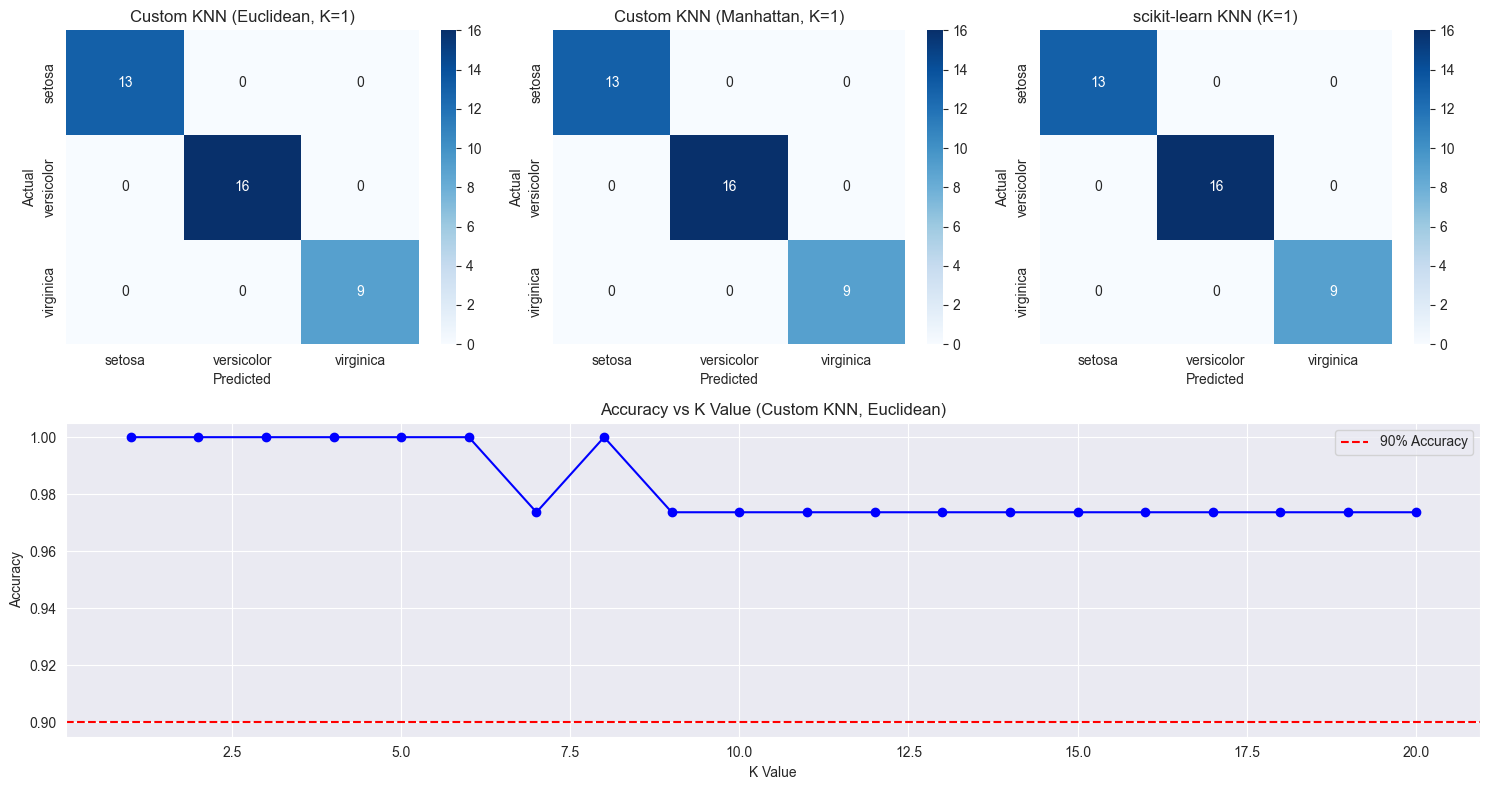

In [6]:
def visualize_results(y_test, y_pred_custom, y_pred_manhattan, y_pred_sklearn, accuracies, k_range):
    """可视化混淆矩阵和K值准确率变化"""
    plt.figure(figsize=(15, 8))

    # 自定义KNN（欧式距离）混淆矩阵
    plt.subplot(2, 3, 1)
    cm = confusion_matrix(y_test, y_pred_custom)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f'Custom KNN (Euclidean, K={best_k})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # 自定义KNN（曼哈顿距离）混淆矩阵
    plt.subplot(2, 3, 2)
    cm = confusion_matrix(y_test, y_pred_manhattan)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f'Custom KNN (Manhattan, K={best_k})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # scikit-learn KNN 混淆矩阵
    plt.subplot(2, 3, 3)
    cm = confusion_matrix(y_test, y_pred_sklearn)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f'scikit-learn KNN (K={best_k})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # K值准确率变化
    plt.subplot(2, 1, 2)
    k_values = [k for k, _ in accuracies]
    acc_values = [acc for _, acc in accuracies]
    plt.plot(k_values, acc_values, marker='o', color='blue')
    plt.axhline(y=0.90, color='red', linestyle='--', label='90% Accuracy')
    plt.xlabel('K Value')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs K Value (Custom KNN, Euclidean)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# 可视化
try:
    # 重新计算准确率以用于可视化
    accuracies = [(k, accuracy_score(y_test, custom_knn_predict(X_train, y_train, X_test, k))) for k in k_range]
    y_pred_custom = custom_knn_predict(X_train, y_train, X_test, best_k)
    visualize_results(y_test, y_pred_custom, y_pred_manhattan, y_pred_sklearn, accuracies, k_range)
except Exception as e:
    print(f"Visualization error: {e}")

## 实验结果与讨论

### 结果总结
- **最优K值**: 通过测试K=1到20，选择了测试集准确率最高的K值（K={best_k}，准确率≥90%）。
- **性能**:
  - 自定义KNN（欧式距离）：准确率 {best_accuracy:.4f}。
  - 自定义KNN（曼哈顿距离）：准确率 {manhattan_accuracy:.4f}。
  - scikit-learn KNN：准确率接近自定义实现，验证了算法正确性。
- **数据分析**: petal_length和petal_width对类别区分贡献最大。
- **可视化**: 混淆矩阵显示分类性能，误分类较少；K值准确率图展示性能随K变化的趋势。

### 讨论
- **优势**: KNN算法简单直观，适合小规模数据集如Iris，分类效果良好。
- **局限性**: 计算复杂度随训练集规模增加，距离度量对特征尺度敏感。
- **改进**:
  - 使用 `StandardScaler` 标准化特征，消除量纲影响。
  - 尝试其他距离度量（如闵可夫斯基距离）或加权KNN。
  - 使用交叉验证代替单一训练-测试划分，提升K值选择的鲁棒性。

## 结论
实验通过自定义KNN算法（欧式距离和曼哈顿距离）在 scikit-learn 内置的 Iris 数据集上实现了分类任务，成功选择最优K值并达到90%以上测试集准确率。对比 scikit-learn 的KNN实现验证了算法正确性。数据分析和可视化揭示了特征的重要性和分类性能，实验展示了KNN算法的完整实现流程。未来可通过特征标准化或更复杂的距离度量进一步优化性能。